In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [2]:
%load_ext autoreload
%autoreload 1

In [21]:
%aimport prophet_projpred
%aimport prophet_projpred.models
%aimport prophet_projpred.family

In [4]:
df = pd.read_csv('data/ecuador_dataset.csv')
df

,family,date,unit_sales,onpromotion,items,oil_price,precipitation,tavg,tmax,tmin,yellow maize,rice,white maize,wheat flour,wheat,potatoes
0,AUTOMOTIVE,2013-01-02,123.000,0.0,20.0,93.14,0.0,13.80,17.4,5.00,18.07,1.04,0.58,38.0,17.27,0.35
1,AUTOMOTIVE,2013-01-03,82.000,0.0,20.0,92.97,0.0,13.80,18.6,7.20,18.07,1.04,0.58,38.0,17.27,0.35
2,AUTOMOTIVE,2013-01-04,71.000,0.0,20.0,93.12,0.8,13.70,18.6,8.00,18.07,1.04,0.58,38.0,17.27,0.35
3,AUTOMOTIVE,2013-01-05,184.000,0.0,20.0,93.12,0.0,14.45,19.9,7.35,18.07,1.04,0.58,38.0,17.27,0.35
4,AUTOMOTIVE,2013-01-06,198.000,0.0,20.0,93.12,2.0,15.20,21.2,6.70,18.07,1.04,0.58,38.0,17.27,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55369,SEAFOOD,2017-08-10,433.118,0.0,8.0,48.54,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55370,SEAFOOD,2017-08-11,765.204,73.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55371,SEAFOOD,2017-08-12,613.881,6.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55372,SEAFOOD,2017-08-13,700.469,0.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30


In [5]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [25]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, holidays=holidays, mcmc_samples=100)

In [26]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [27]:
future = df.copy()
future['date']=pd.to_datetime(future['date'])
future = future.loc[
    future['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
print(future.info())
future = future.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
future = future.loc['2015-05-01':'2017-04-30',:].reset_index()
future = future.rename(columns={'date': 'ds', 'unit_sales': 'y'})
future[['y', 'onpromotion']] = np.log(future[['y', 'onpromotion']])
future

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15102 entries, 5034 to 52017
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   family         15102 non-null  object        
 1   date           15102 non-null  datetime64[ns]
 2   unit_sales     15102 non-null  float64       
 3   onpromotion    15102 non-null  float64       
 4   oil_price      15102 non-null  float64       
 5   precipitation  15102 non-null  float64       
 6   tavg           15102 non-null  float64       
 7   tmax           15102 non-null  float64       
 8   tmin           15102 non-null  float64       
 9   yellow maize   15102 non-null  float64       
 10  potatoes       15102 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 1.4+ MB
None


,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
722,2017-04-26,12.627005,8.656259,49.22,0.0,18.400000,8.000000,11.700000,21.271667,0.345333
723,2017-04-27,12.337720,8.136226,48.96,22.1,20.200000,7.800000,13.800000,21.160000,0.344000
724,2017-04-28,12.658976,8.629986,49.31,0.0,20.033333,7.716667,13.816667,21.048333,0.342667
725,2017-04-29,12.939686,8.144679,49.31,0.0,19.866667,7.633333,13.833333,20.936667,0.341333


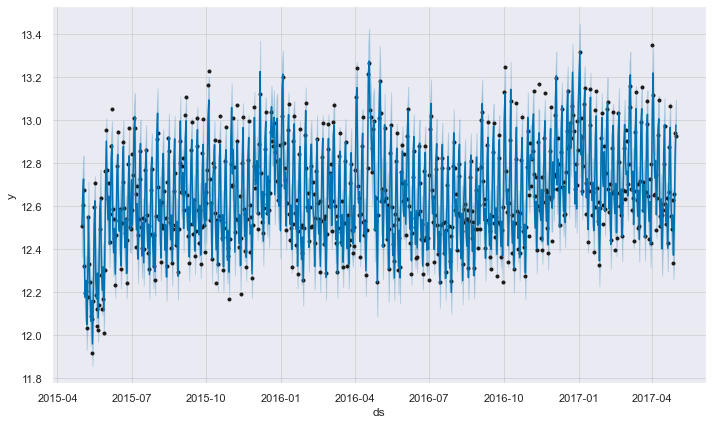

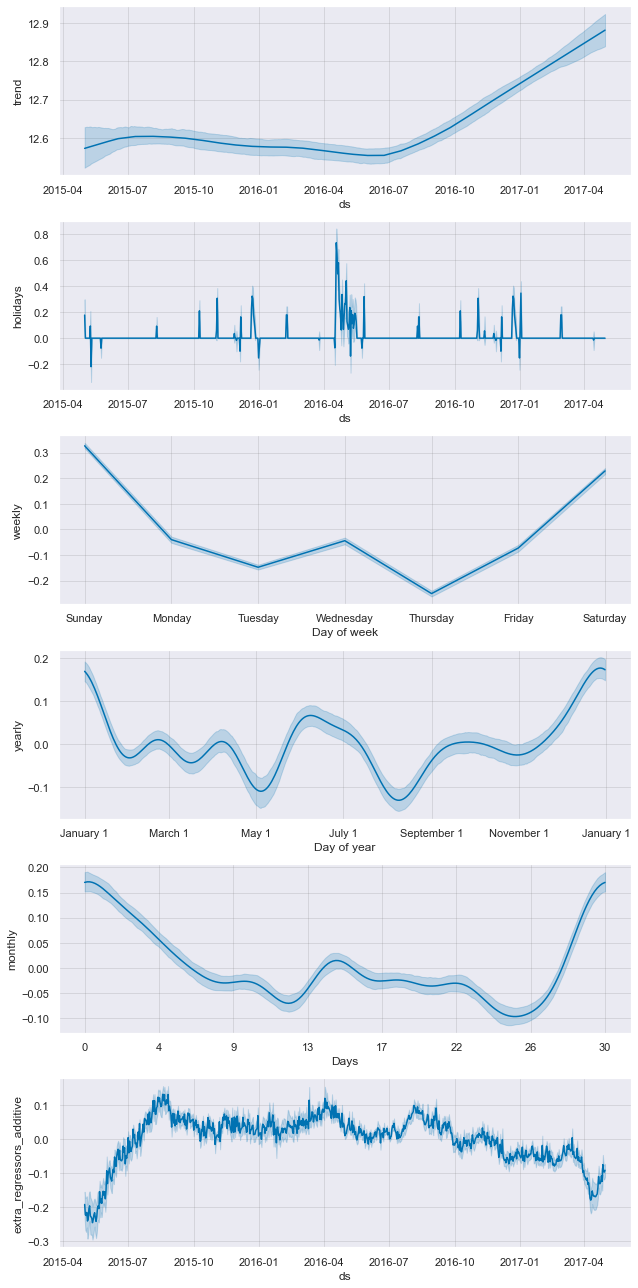

In [28]:
m.fit(future)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [11]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '30 days')

  0%|          | 0/6 [00:00<?, ?it/s]

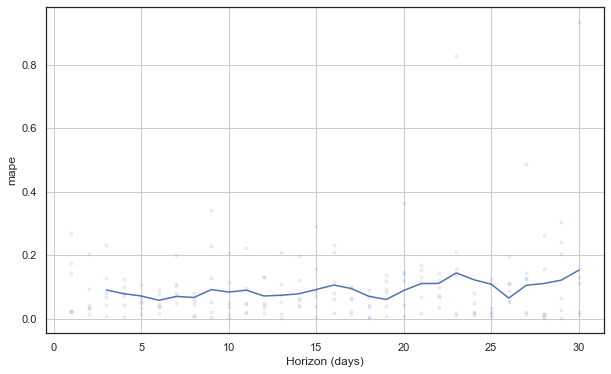

In [12]:
from prophet.plot import plot_cross_validation_metric

exp_df_cv = df_cv.copy()
exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(exp_df_cv, metric='mape')

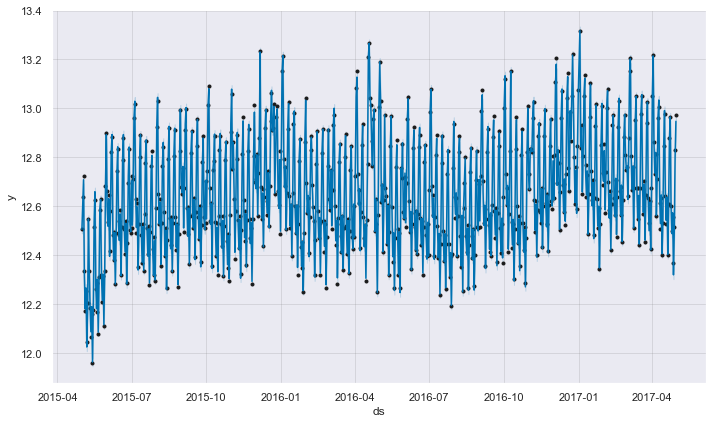

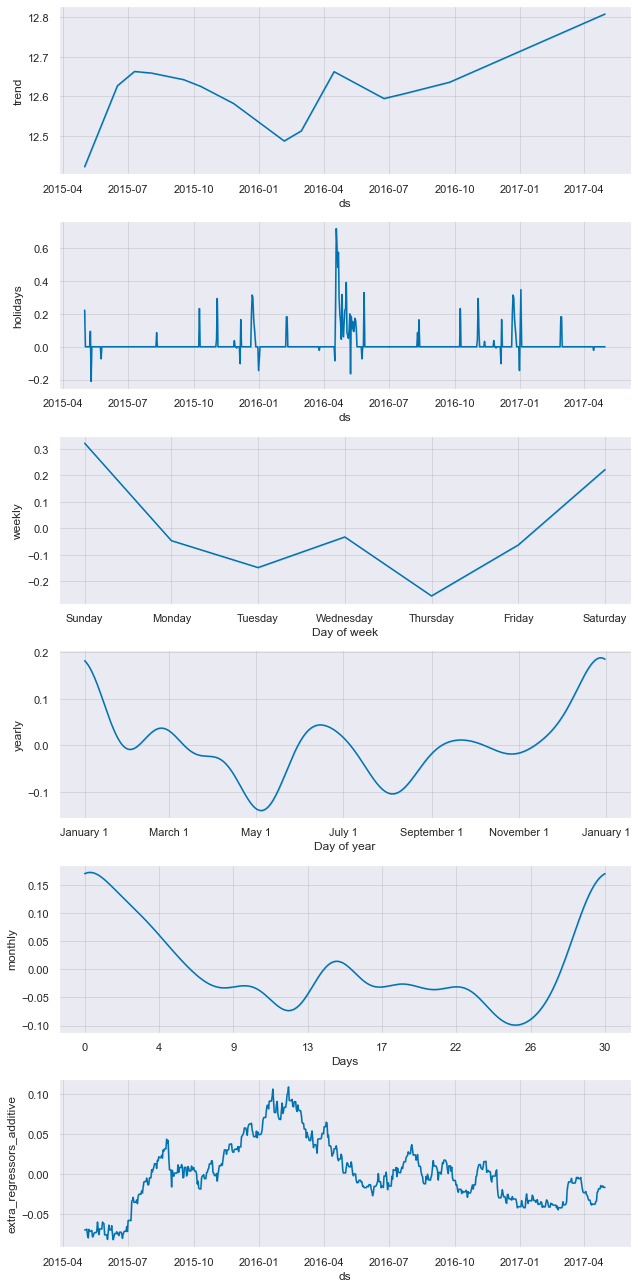

In [10]:
projection, submodel = m.project(future, ['oil_price'])

fig1 = submodel.plot(projection)
fig2 = submodel.plot_components(projection)

In [32]:
path = m.search(future)

        variable        kl
0      oil_price  0.113242
1           tavg  0.139951
2   yellow_maize  0.146477
3       potatoes  0.162378
4    onpromotion  0.167305
5  precipitation  0.168156
6           tmax  0.174884
7           tmin  0.176642
        variable        kl
0           tavg  0.066635
1    onpromotion  0.097678
2   yellow_maize  0.099989
3  precipitation  0.100693
4           tmax  0.108161
5       potatoes  0.109797
6           tmin  0.112349
        variable        kl
0  precipitation  0.027535
1   yellow_maize  0.050443
2    onpromotion  0.050569
3       potatoes  0.063732
4           tmax  0.064489
5           tmin  0.066598
       variable        kl
0   onpromotion  0.011898
1  yellow_maize  0.017439
2      potatoes  0.023683
3          tmax  0.025062
4          tmin  0.025909
       variable        kl
0  yellow_maize  0.003297
1      potatoes  0.008778
2          tmax  0.010420
3          tmin  0.011438
   variable        kl
0      tmax  0.000590
1      tmin  0.003027


In [33]:
path

[['oil_price'],
 ['oil_price', 'tavg'],
 ['oil_price', 'tavg', 'precipitation'],
 ['oil_price', 'tavg', 'precipitation', 'onpromotion'],
 ['oil_price', 'tavg', 'precipitation', 'onpromotion', 'yellow_maize'],
 ['oil_price', 'tavg', 'precipitation', 'onpromotion', 'yellow_maize', 'tmax'],
 ['oil_price',
  'tavg',
  'precipitation',
  'onpromotion',
  'yellow_maize',
  'tmax',
  'tmin'],
 ['oil_price',
  'tavg',
  'precipitation',
  'onpromotion',
  'yellow_maize',
  'tmax',
  'tmin',
  'potatoes']]

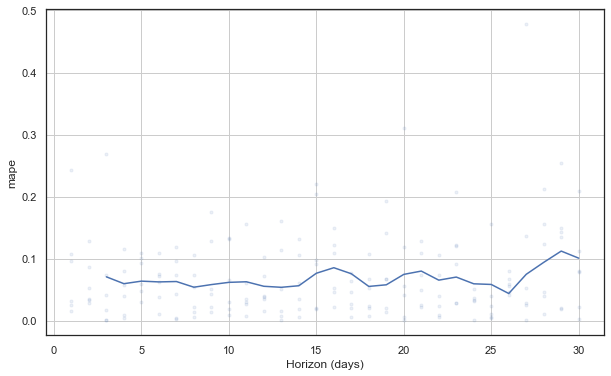

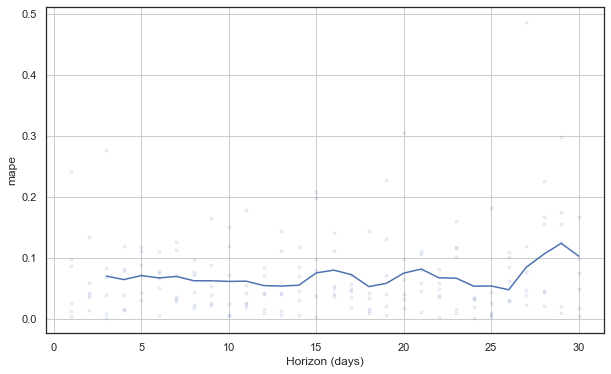

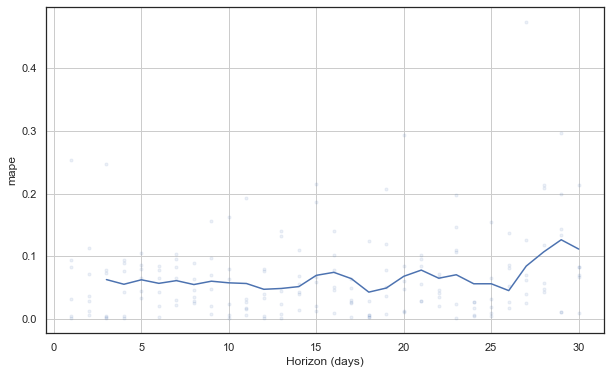

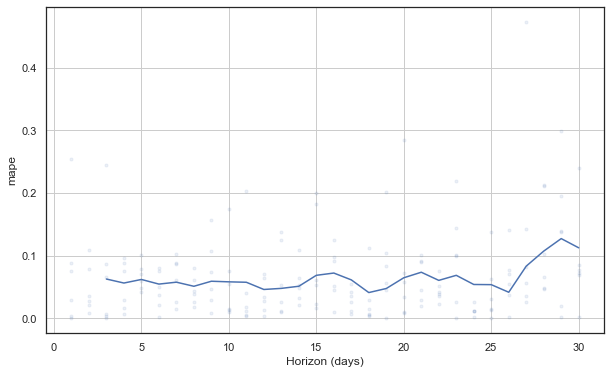

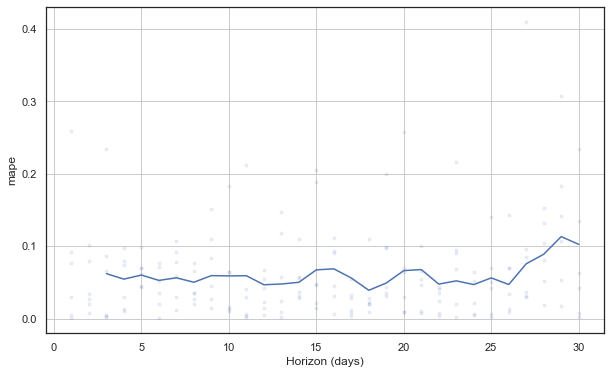

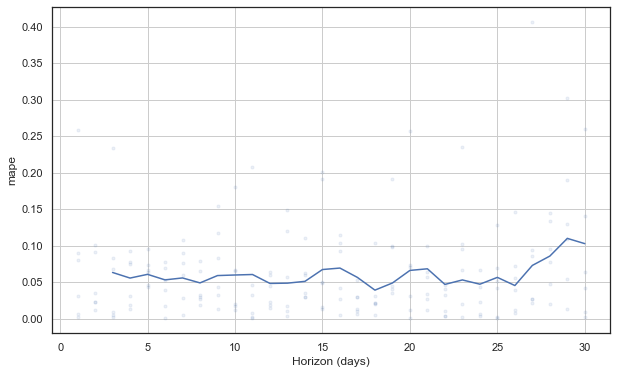

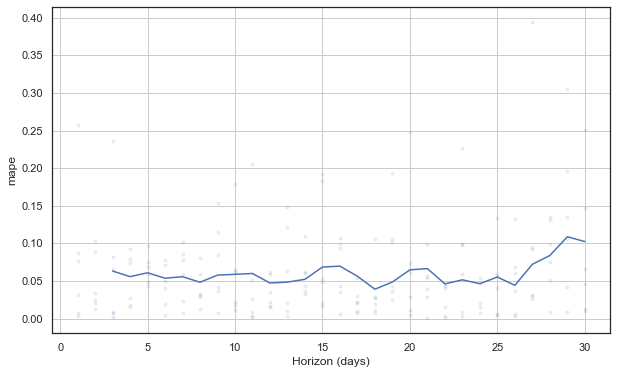

In [23]:
from prophet.plot import plot_cross_validation_metric
for cv in validations:
    exp_cv = cv.copy()
    exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
    #Measure performance relative to the original data (not reference predictions)
    exp_cv[['y']]=np.exp(df_cv[['y']])
    with sns.axes_style('white'):
        fig = plot_cross_validation_metric(exp_cv, metric='mape')

In [37]:
sf = m.stan_backend.stan_fit

In [44]:
sf.to_dataframe()

,chain,draw,warmup,k,m,delta[1],delta[2],delta[3],delta[4],delta[5],...,trend[725],trend[726],trend[727],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.041532,0.940839,-0.003103,0.007575,-0.060793,-0.008392,0.007009,...,0.961533,0.961596,0.961660,3301.224024,0.987677,0.000120,10,1023,0,-3217.955937
1,0,1,0,0.033279,0.942587,0.010154,-0.053907,-0.009956,0.017645,-0.004966,...,0.964514,0.964607,0.964700,3290.612958,0.668439,0.000120,10,1023,0,-3208.597382
2,0,2,0,0.064281,0.939244,-0.021101,0.016792,-0.049752,-0.022449,-0.002346,...,0.963603,0.963683,0.963763,3288.224534,0.958682,0.000120,10,1023,0,-3214.644631
3,0,3,0,0.104264,0.939509,-0.021180,-0.097049,0.013235,0.002559,-0.002830,...,0.964875,0.964974,0.965072,3295.550484,0.958128,0.000120,10,1023,0,-3222.902685
4,0,4,0,0.106653,0.938464,0.019383,-0.131314,-0.029636,0.003090,0.008235,...,0.965075,0.965159,0.965243,3286.858036,0.940946,0.000120,10,1023,0,-3220.164280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3,45,0,-0.030341,0.943072,0.021796,-0.012454,0.012118,-0.026382,0.029027,...,0.967153,0.967238,0.967322,3248.519962,0.623521,0.000143,10,1023,0,-3165.940543
196,3,46,0,0.076390,0.935029,0.000725,-0.044297,-0.014972,0.017485,-0.049032,...,0.965761,0.965846,0.965932,3266.003817,0.973618,0.000143,10,1023,0,-3178.124618
197,3,47,0,-0.014688,0.944941,-0.002640,0.007530,0.017160,-0.005446,-0.022781,...,0.965758,0.965859,0.965960,3289.142438,0.989382,0.000143,10,1023,0,-3187.690843
198,3,48,0,0.054299,0.938263,-0.000392,-0.010230,-0.007902,0.006922,-0.047063,...,0.965051,0.965135,0.965219,3282.756221,0.619042,0.000143,10,1023,0,-3193.343097


In [67]:
m.predictive_samples(future)['yhat'][:,0]

array([12.5052465 , 12.58970851, 12.71270611, 12.34572775, 12.3426334 ,
       12.10821423, 11.992621  , 12.2564372 , 12.3760646 , 12.15476531,
       12.04170356, 12.06524984, 12.12969114, 11.94035575, 12.2067551 ,
       12.44328368, 12.72654411, 12.31649061, 12.13458595, 12.23219733,
       12.10510663, 12.31285925, 12.5314569 , 12.62428283, 12.31415233,
       12.05010635, 12.31150804, 12.09628857, 12.38527742, 12.83909204,
       12.82102663, 12.66279171, 12.60123982, 12.56303812, 12.31838014,
       12.63421804, 12.74191293, 13.05325081, 12.49786302, 12.35987594,
       12.40132693, 12.25055103, 12.39261367, 12.85731194, 12.77030862,
       12.43108059, 12.38505203, 12.65422704, 12.35732145, 12.43217458,
       12.81583592, 12.81609601, 12.49841925, 12.21954251, 12.46853233,
       12.21558722, 12.29544627, 12.62451381, 12.86433565, 12.52135581,
       12.40516323, 12.76752548, 12.54537078, 12.84175858, 12.942593  ,
       13.04038141, 12.51422111, 12.45693342, 12.5411156 , 12.37